开始训练 R-MNet...
Epoch 1, Loss: 0.5243
Epoch 2, Loss: 0.4434
Epoch 3, Loss: 0.4053
Epoch 4, Loss: 0.3861
Epoch 5, Loss: 0.3690
Epoch 6, Loss: 0.3536
Epoch 7, Loss: 0.3455
Epoch 8, Loss: 0.3348
Epoch 9, Loss: 0.3285
Epoch 10, Loss: 0.3209
Epoch 11, Loss: 0.3126
Epoch 12, Loss: 0.3022
Epoch 13, Loss: 0.3005
Epoch 14, Loss: 0.2914
Epoch 15, Loss: 0.2868
Epoch 16, Loss: 0.2800
Epoch 17, Loss: 0.2738
Epoch 18, Loss: 0.2670
Epoch 19, Loss: 0.2629
Epoch 20, Loss: 0.2568
Epoch 21, Loss: 0.2520
Epoch 22, Loss: 0.2464
Epoch 23, Loss: 0.2422
Epoch 24, Loss: 0.2377
Epoch 25, Loss: 0.2348
Epoch 26, Loss: 0.2281
Epoch 27, Loss: 0.2258
Epoch 28, Loss: 0.2201
Epoch 29, Loss: 0.2146
Epoch 30, Loss: 0.2112
Epoch 31, Loss: 0.2082
Epoch 32, Loss: 0.2030
Epoch 33, Loss: 0.1986
Epoch 34, Loss: 0.1944
Epoch 35, Loss: 0.1918
Epoch 36, Loss: 0.1874
Epoch 37, Loss: 0.1837
Epoch 38, Loss: 0.1820
Epoch 39, Loss: 0.1783
Epoch 40, Loss: 0.1745
训练完成，模型已保存为 hair_seg_rmnet.pth
保存完成：./inpainted_ISIC2019_0000461.png


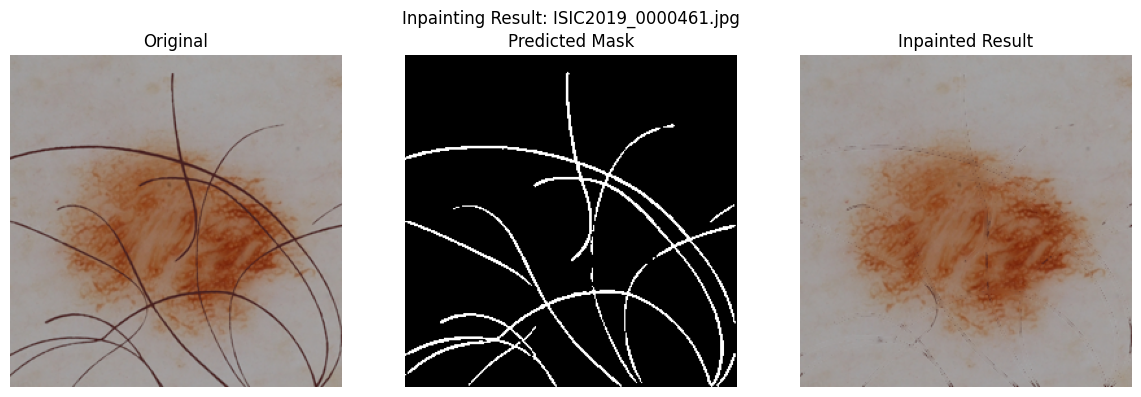

保存完成：./inpainted_ISIC2019_0031696.png


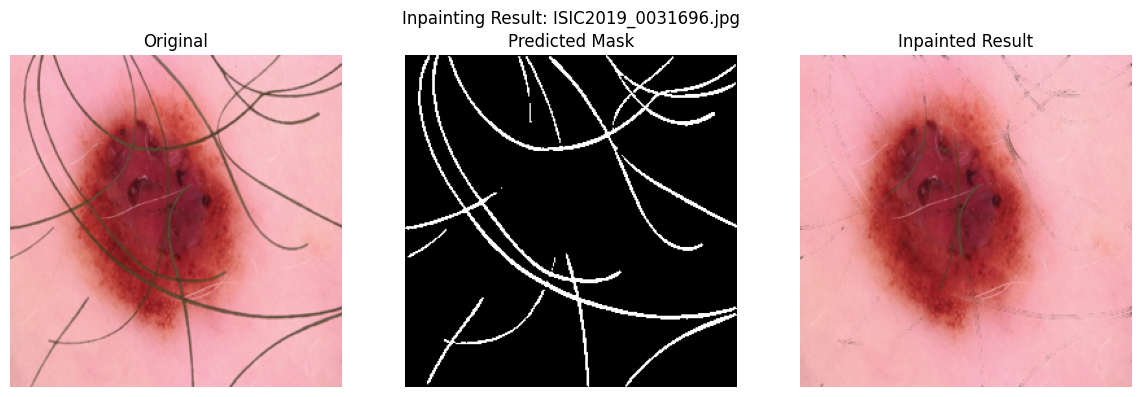

保存完成：./inpainted_ISIC2019_0028326.png


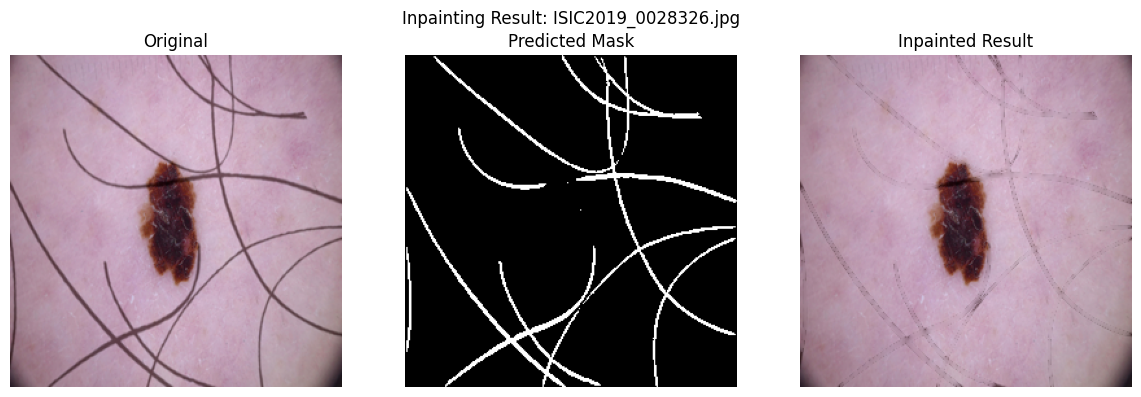

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# -------------------- 数据集定义 --------------------
class HairMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform_img=None, transform_mask=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_list = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        self.transform_img = transform_img
        self.transform_mask = transform_mask

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_name = self.image_list[idx]
        image = Image.open(os.path.join(self.image_dir, image_name)).convert('RGB')
        mask = Image.open(os.path.join(self.mask_dir, image_name)).convert('L')
        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_mask:
            mask = self.transform_mask(mask)
        return image, mask

# -------------------- R-MNet 模型定义 --------------------
class RMNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(RMNet, self).__init__()
        def conv_bn_relu(in_c, out_c, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p, bias=False),
                nn.BatchNorm2d(out_c),
                nn.ReLU(inplace=True)
            )

        self.stage1 = conv_bn_relu(in_channels, 32)
        self.stage2 = conv_bn_relu(32, 64)
        self.stage3 = conv_bn_relu(64, 128)
        self.stage4 = conv_bn_relu(128, 64)
        self.stage5 = conv_bn_relu(64, 32)
        self.final = nn.Conv2d(32, out_channels, kernel_size=1)

    def forward(self, x):
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.stage4(x)
        x = self.stage5(x)
        x = torch.sigmoid(self.final(x))
        return x

# -------------------- 数据预处理与加载 --------------------
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
transform_mask = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset = HairMaskDataset(
    image_dir='/root/autodl-fs/skin_hair_dataset/alignment/photo with hair',
    mask_dir='/root/autodl-fs/skin_hair_dataset/alignment/mask',
    transform_img=transform_img,
    transform_mask=transform_mask
)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# -------------------- 训练模型 --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RMNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

print("开始训练 R-MNet...")
for epoch in range(40):
    model.train()
    total_loss = 0
    for imgs, masks in dataloader:
        imgs, masks = imgs.to(device), masks.to(device)
        preds = model(imgs)
        loss = criterion(preds, masks)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.4f}")

torch.save(model.state_dict(), "hair_seg_rmnet.pth")
print("训练完成，模型已保存为 hair_seg_rmnet.pth")

# -------------------- 修复函数定义 --------------------
def inpaint_image(image_path, save_path=None):
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)
    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype('uint8') * 255
    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(image_cv, binary_mask, 3, cv2.INPAINT_TELEA)
    if save_path:
        cv2.imwrite(save_path, inpainted)
    return inpainted, image_cv, binary_mask

# -------------------- 可视化示例 --------------------
image_names = ['ISIC2019_0000461.jpg', 'ISIC2019_0031696.jpg', 'ISIC2019_0028326.jpg']
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"

for img_name in image_names:
    img_path = os.path.join(image_dir, img_name)
    output_path = f"./inpainted_{img_name.split('.')[0]}.png"
    inpainted, original, mask = inpaint_image(img_path, output_path)

    print(f"保存完成：{output_path}")
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB))
    plt.title("Inpainted Result")
    plt.axis('off')

    plt.suptitle(f"Inpainting Result: {img_name}")
    plt.tight_layout()
    plt.show()


In [2]:
import os
import cv2
import numpy as np
import torch
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from sewar.full_ref import uqi
from PIL import Image
from torchvision import transforms

# 图像预处理
transform_img = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# 加载模型（假设模型已定义并训练好）
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RMNet().to(device)
model.load_state_dict(torch.load("hair_seg_rmnet.pth"))
model.eval()

# 修复函数（不保存图像）
def inpaint_image(image_path):
    image = Image.open(image_path).convert("RGB").resize((256, 256))
    input_tensor = transform_img(image).unsqueeze(0).to(device)

    with torch.no_grad():
        pred_mask = model(input_tensor).squeeze().cpu().numpy()
    binary_mask = (pred_mask > 0.5).astype('uint8') * 255

    image_cv = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    inpainted = cv2.inpaint(image_cv, binary_mask, 3, cv2.INPAINT_TELEA)

    return inpainted, image_cv, binary_mask

# 指标计算函数
def compute_metrics(original, inpainted):
    original_rgb = cv2.cvtColor(original, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    inpainted_rgb = cv2.cvtColor(inpainted, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

    mse = mean_squared_error(original_rgb, inpainted_rgb)
    psnr = peak_signal_noise_ratio(original_rgb, inpainted_rgb, data_range=1.0)
    ssim = structural_similarity(original_rgb, inpainted_rgb, channel_axis=2, data_range=1.0)

    original_uint8 = (original_rgb * 255).astype(np.uint8)
    inpainted_uint8 = (inpainted_rgb * 255).astype(np.uint8)
    uqi_value = uqi(original_uint8, inpainted_uint8)

    return mse, psnr, ssim, uqi_value

# 图像目录
image_dir = "/root/autodl-fs/skin_hair_dataset/alignment/photo with hair"
image_names = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

# 初始化指标列表
mse_list, psnr_list, ssim_list, uqi_list = [], [], [], []

# 批量处理
for img_name in image_names:
    img_path = os.path.join(image_dir, img_name)
    inpainted, original, _ = inpaint_image(img_path)
    mse, psnr, ssim, uqi_value = compute_metrics(original, inpainted)
    mse_list.append(mse)
    psnr_list.append(psnr)
    ssim_list.append(ssim)
    uqi_list.append(uqi_value)

# 计算平均指标
avg_mse = sum(mse_list) / len(mse_list)
avg_psnr = sum(psnr_list) / len(psnr_list)
avg_ssim = sum(ssim_list) / len(ssim_list)
avg_uqi = sum(uqi_list) / len(uqi_list)

# 打印结果
print("平均指标：")
print(f"  MSE  : {avg_mse:.6f}")
print(f"  PSNR : {avg_psnr:.2f} dB")
print(f"  SSIM : {avg_ssim:.4f}")
print(f"  UQI  : {avg_uqi:.4f}")


/tmp/ipykernel_3933/2357021094.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("hair_seg_rmnet.pth"))


平均指标：
  MSE  : 0.003521
  PSNR : 26.34 dB
  SSIM : 0.8950
  UQI  : 0.9928
